In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import lightgbm as lgb

* Carga de datos

In [8]:
df = pd.read_csv('../../../data/loan_dataset.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


* Exploracion inicial de datos

In [9]:
print("Estructura del Dataset:")
print(df.info())

print("\nResumen Estadístico:")
print(df.describe())

print("\nValores Faltantes:")
print(df.isnull().sum())

Estructura del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None

Resumen Estadístico:
       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_A

* Analisis estadistico y descriptivo

In [10]:
variables_categoricas = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
for var in variables_categoricas:
    print(f"\nDistribución de {var}:")
    print(df[var].value_counts(normalize=True))

# Variables numéricas
variables_numericas = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
for var in variables_numericas:
    print(f"\nEstadísticas de {var}:")
    print(df[var].describe())


Distribución de Gender:
Gender
Male      0.813644
Female    0.186356
Name: proportion, dtype: float64

Distribución de Married:
Married
Yes    0.651391
No     0.348609
Name: proportion, dtype: float64

Distribución de Education:
Education
Graduate        0.781759
Not Graduate    0.218241
Name: proportion, dtype: float64

Distribución de Self_Employed:
Self_Employed
No     0.859107
Yes    0.140893
Name: proportion, dtype: float64

Distribución de Property_Area:
Property_Area
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: proportion, dtype: float64

Distribución de Loan_Status:
Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64

Estadísticas de ApplicantIncome:
count      614.000000
mean      5403.459283
std       6109.041673
min        150.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64

Estadísticas de CoapplicantIncome:
count      614.000000
mean      16

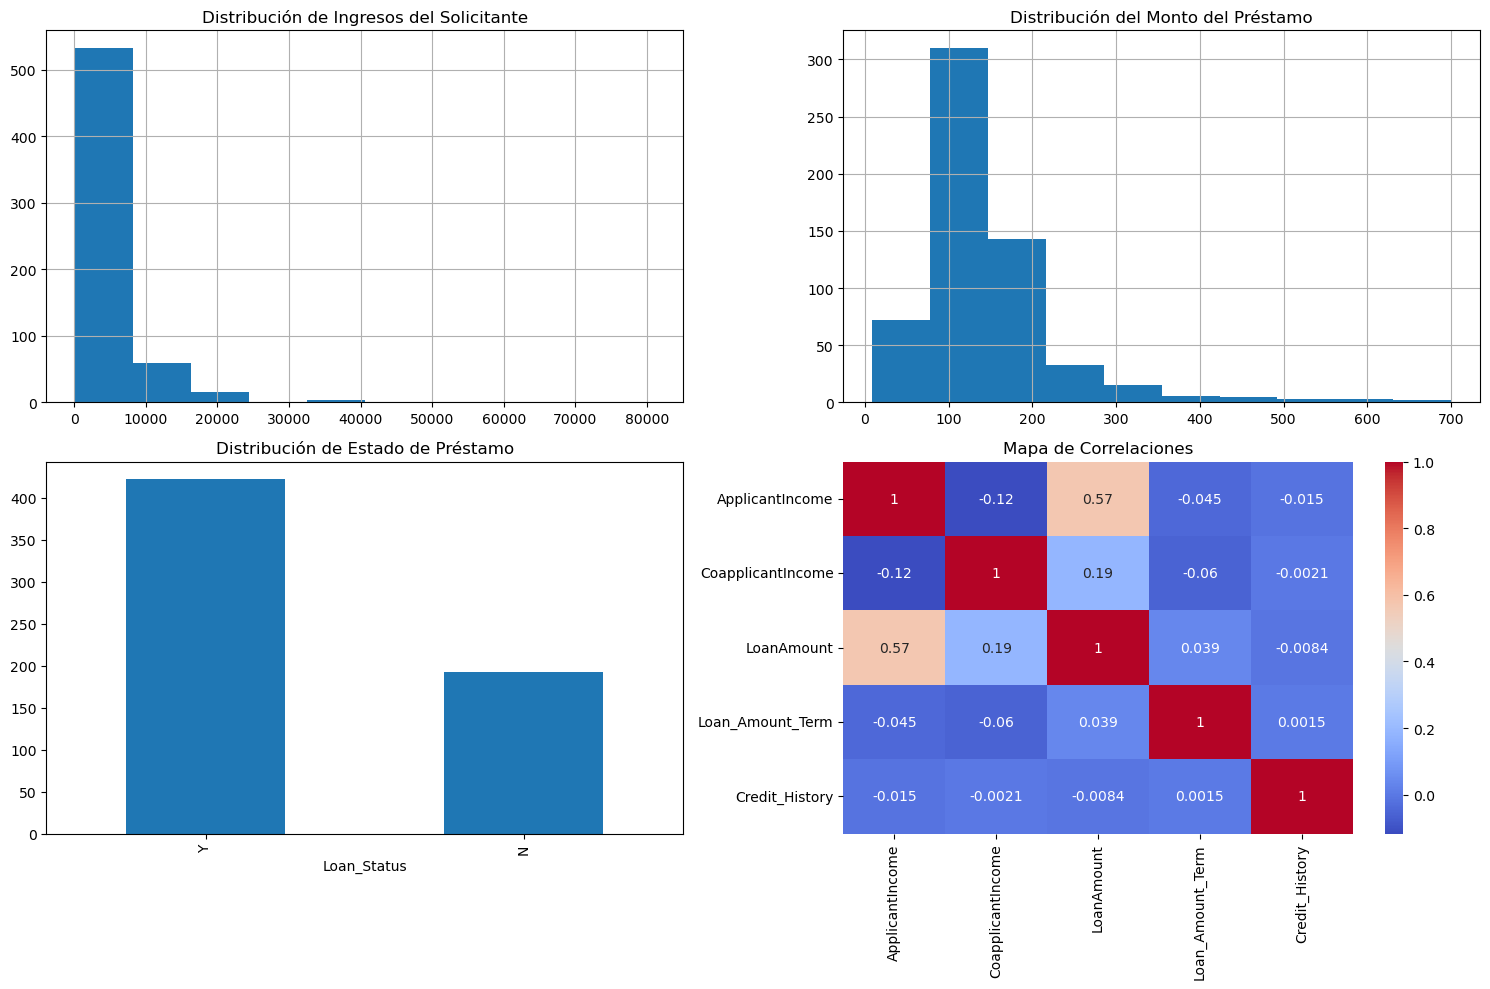

In [11]:
# Visualizaciones

plt.figure(figsize=(15, 10))

# Histogramas
plt.subplot(2, 2, 1)
df['ApplicantIncome'].hist()
plt.title('Distribución de Ingresos del Solicitante')

plt.subplot(2, 2, 2)
df['LoanAmount'].hist()
plt.title('Distribución del Monto del Préstamo')

# Gráfico de barras para variables categóricas
plt.subplot(2, 2, 3)
df['Loan_Status'].value_counts().plot(kind='bar')
plt.title('Distribución de Estado de Préstamo')

# Mapa de calor de correlaciones
plt.subplot(2, 2, 4)
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa de Correlaciones')

plt.tight_layout()
plt.show()

* Preprocesamiento de datos 

In [12]:
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status'].map({'Y': 1, 'N': 0})

# Columnas
categoricas = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
numericas = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas)
    ])

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

* Entrenamiento

In [13]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(random_state=42))
])

# Parámetros para GridSearch
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__max_depth': [3, 5, 7]
}

# GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Mejores parámetros
print("Mejores parámetros:", grid_search.best_params_)

# Predicciones
y_pred = grid_search.predict(X_test)

# Métricas de evaluación
print("\nMétricas de Rendimiento:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-Score: {f1_score(y_test, y_pred)}")

c:\Users\Ivan\miniconda3\envs\env_ds\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Ivan\miniconda3\envs\env_ds\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Ivan\miniconda3\envs\env_ds\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ivan\miniconda3\envs\env_ds\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Ivan\miniconda3\envs\env_ds\Lib\subprocess.py", line 1538

[LightGBM] [Info] Number of positive: 228, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.697248 -> initscore=0.834226
[LightGBM] [Info] Start training from score 0.834226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L